# Analysis of Motor Vehicle Collisions in New York City with PySpark and MapReduce

In [22]:
CRASHES_URL = "https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD"
VEHICLES_URL = "https://data.cityofnewyork.us/api/views/bm4k-52h4/rows.csv?accessType=DOWNLOAD"
BUCKET_NAME = "bucket-dia-x23185813"
CRASHES_FILE_NAME = "Crashes.csv"
VEHICLES_FILE_NAME = "Vehicles.csv"
PROJECT_ID= !gcloud config get-value project
PATH = "notebooks/jupyter/dataset"
STORAGE_CLASS="standard"

bucket_exists = !gsutil ls gs://{BUCKET_NAME}
if f'BucketNotFoundException: 404 gs://{BUCKET_NAME} bucket does not exist.' in bucket_exists:
    print("Creating the bucket.")
    !gsutil mb -p {PROJECT_ID[0]} -c {STORAGE_CLASS} -l eu gs://{BUCKET_NAME}
else:
    print("Bucket already exists")
    
    
# Check if the Crashes file exists in the bucket and download if it does not
crashes_exists = !gsutil ls gs://{BUCKET_NAME}/{PATH}/{CRASHES_FILE_NAME}
if 'CommandException: One or more URLs matched no objects.' in crashes_exists:
    !wget {CRASHES_URL} -O /tmp/{CRASHES_FILE_NAME}
    !gsutil cp /tmp/{CRASHES_FILE_NAME} gs://{BUCKET_NAME}/{PATH}/
    !rm /tmp/{CRASHES_FILE_NAME}
elif f'BucketNotFoundException: 404 gs://{BUCKET_NAME} bucket does not exist.' in  crashes_exists:
    print("Error: Bucket does not exist")
else:
    print("Crashes dataset already exists in GCS. Skipping download.")

# Check if the Vehicles file exists in the bucket and download if it does not
vehicles_exists = !gsutil ls gs://{BUCKET_NAME}/{PATH}/{VEHICLES_FILE_NAME}
if 'CommandException: One or more URLs matched no objects.' in vehicles_exists:
    !wget {VEHICLES_URL} -O /tmp/{VEHICLES_FILE_NAME}
    !gsutil cp /tmp/{VEHICLES_FILE_NAME} gs://{BUCKET_NAME}/{PATH}/
    !rm /tmp/{VEHICLES_FILE_NAME}
elif f'BucketNotFoundException: 404 gs://{BUCKET_NAME} bucket does not exist.' in  vehicles_exists:
    print("Error: Bucket does not exist")
else:
    print("Vehicles dataset already exists in GCS. Skipping download.")

Crashes dataset already exists in GCS. Skipping download.
Vehicles dataset already exists in GCS. Skipping download.


### Load libraries and define functions

In [23]:
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import  to_timestamp, hour, col, concat, lit, count,when
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType


%matplotlib inline
sns.set_theme(style="whitegrid", palette="viridis", font_scale=1.2)

spark = SparkSession.builder \
    .appName("DIA") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate() 

def data_desc(df):
    total_rows = df.count()
    total_columns = len(df.columns)
    print(f"Total number of rows: {total_rows}")
    print(f"Total number of columns: {total_columns}")
    df.show(5,0,vertical=True)

def drop_columns(df, threshold):
    """
    Drop columns from a DataFrame where the percentage of null values exceeds a specified threshold.

    :param df: DataFrame to process
    :param threshold_percentage: Threshold as a percentage (e.g., 0.5 for 50%)
    :return: DataFrame with columns dropped based on threshold
    """
    # Total number of rows
    total_rows = df.count()

    # Calculate the count of nulls for each column in one go
    null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

    # Convert row to dictionary: {column_name: null_count}
    null_counts_dict = null_counts.collect()[0].asDict()

    # Calculate the actual threshold count based on the given percentage
    actual_threshold = total_rows * threshold

    # Identify columns where the percentage of nulls exceeds the threshold
    cols_to_drop = [c for c, count in null_counts_dict.items() if count > actual_threshold]

    # Drop these columns
    df = df.drop(*cols_to_drop)


    return df

24/05/20 14:49:25 INFO SparkEnv: Registering MapOutputTracker
24/05/20 14:49:25 INFO SparkEnv: Registering BlockManagerMaster
24/05/20 14:49:25 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/05/20 14:49:25 INFO SparkEnv: Registering OutputCommitCoordinator


### Load the data

#### Crashes data

In [24]:
crashes_path = "gs://bucket-dia-x23185813/notebooks/jupyter/dataset/Crashes.csv" 

crashes_schema = StructType([
    StructField("CRASH_DATE", StringType(), True),  
    StructField("CRASH_TIME", StringType(), True),  
    StructField("BOROUGH", StringType(), True),
    StructField("ZIP_CODE", IntegerType(), True),
    StructField("LATITUDE", DoubleType(), True),
    StructField("LONGITUDE", DoubleType(), True),
    StructField("LOCATION", StringType(), True),
    StructField("ON_STREET_NAME", StringType(), True),
    StructField("CROSS_STREET_NAME", StringType(), True),
    StructField("OFF_STREET_NAME", StringType(), True),
    StructField("NUMBER_OF_PERSONS_INJURED", IntegerType(), True),
    StructField("NUMBER_OF_PERSONS_KILLED", IntegerType(), True),
    StructField("NUMBER_OF_PEDESTRIANS_INJURED", IntegerType(), True),
    StructField("NUMBER_OF_PEDESTRIANS_KILLED", IntegerType(), True),
    StructField("NUMBER_OF_CYCLIST_INJURED", IntegerType(), True),
    StructField("NUMBER_OF_CYCLIST_KILLED", IntegerType(), True),
    StructField("NUMBER_OF_MOTORIST_INJURED", IntegerType(), True),
    StructField("NUMBER_OF_MOTORIST_KILLED", IntegerType(), True),
    StructField("CONTRIBUTING_FACTOR_VEHICLE_1", StringType(), True),
    StructField("CONTRIBUTING_FACTOR_VEHICLE_2", StringType(), True),
    StructField("CONTRIBUTING_FACTOR_VEHICLE_3", StringType(), True),
    StructField("CONTRIBUTING_FACTOR_VEHICLE_4", StringType(), True),
    StructField("CONTRIBUTING_FACTOR_VEHICLE_5", StringType(), True),
    StructField("COLLISION_ID", IntegerType(), True),
    StructField("VEHICLE_TYPE_CODE_1", StringType(), True),
    StructField("VEHICLE_TYPE_CODE_2", StringType(), True),
    StructField("VEHICLE_TYPE_CODE_3", StringType(), True),
    StructField("VEHICLE_TYPE_CODE_4", StringType(), True),
    StructField("VEHICLE_TYPE_CODE_5", StringType(), True)
])

crashes_df = spark.read.csv(crashes_path, header=True, schema= crashes_schema)
crashes_df.printSchema()

root
 |-- CRASH_DATE: string (nullable = true)
 |-- CRASH_TIME: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP_CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON_STREET_NAME: string (nullable = true)
 |-- CROSS_STREET_NAME: string (nullable = true)
 |-- OFF_STREET_NAME: string (nullable = true)
 |-- NUMBER_OF_PERSONS_INJURED: integer (nullable = true)
 |-- NUMBER_OF_PERSONS_KILLED: integer (nullable = true)
 |-- NUMBER_OF_PEDESTRIANS_INJURED: integer (nullable = true)
 |-- NUMBER_OF_PEDESTRIANS_KILLED: integer (nullable = true)
 |-- NUMBER_OF_CYCLIST_INJURED: integer (nullable = true)
 |-- NUMBER_OF_CYCLIST_KILLED: integer (nullable = true)
 |-- NUMBER_OF_MOTORIST_INJURED: integer (nullable = true)
 |-- NUMBER_OF_MOTORIST_KILLED: integer (nullable = true)
 |-- CONTRIBUTING_FACTOR_VEHICLE_1: string (nullable = true)
 |-- CONTRIBUTING_FACTOR_VEHICLE_2: s

In [25]:
print("crashes_df : ")
data_desc(crashes_df)

crashes_df : 


Total number of rows: 2088408
Total number of columns: 29


-RECORD 0-----------------------------------------------------
 CRASH_DATE                    | 09/11/2021                   
 CRASH_TIME                    | 2:39                         
 BOROUGH                       | NULL                         
 ZIP_CODE                      | NULL                         
 LATITUDE                      | NULL                         
 LONGITUDE                     | NULL                         
 LOCATION                      | NULL                         
 ON_STREET_NAME                | WHITESTONE EXPRESSWAY        
 CROSS_STREET_NAME             | 20 AVENUE                    
 OFF_STREET_NAME               | NULL                         
 NUMBER_OF_PERSONS_INJURED     | 2                            
 NUMBER_OF_PERSONS_KILLED      | 0                            
 NUMBER_OF_PEDESTRIANS_INJURED | 0                            
 NUMBER_OF_PEDESTRIANS_KILLED  | 0                            
 NUMBER_OF_CYCLIST_INJURED     | 0                     

In [26]:
crashes_df.describe().show(vertical=True)

-RECORD 0---------------------------------------------
 summary                       | count                
 CRASH_DATE                    | 2088408              
 CRASH_TIME                    | 2088408              
 BOROUGH                       | 1438582              
 ZIP_CODE                      | 1438284              
 LATITUDE                      | 1853855              
 LONGITUDE                     | 1853855              
 LOCATION                      | 1853855              
 ON_STREET_NAME                | 1644153              
 CROSS_STREET_NAME             | 1297293              
 OFF_STREET_NAME               | 351883               
 NUMBER_OF_PERSONS_INJURED     | 2088388              
 NUMBER_OF_PERSONS_KILLED      | 2088375              
 NUMBER_OF_PEDESTRIANS_INJURED | 2088406              
 NUMBER_OF_PEDESTRIANS_KILLED  | 2088406              
 NUMBER_OF_CYCLIST_INJURED     | 2088407              
 NUMBER_OF_CYCLIST_KILLED      | 2088406              
 NUMBER_OF

#### Vehicle data

In [27]:
vehicles_path = "gs://bucket-dia-x23185813/notebooks/jupyter/dataset/Vehicles.csv"

vehicles_schema = StructType([
    StructField("UNIQUE_ID", IntegerType(), True),
    StructField("COLLISION_ID", IntegerType(), True),
    StructField("CRASH_DATE", StringType(), True),
    StructField("CRASH_TIME", StringType(), True),
    StructField("VEHICLE_ID", StringType(), True),
    StructField("STATE_REGISTRATION", StringType(), True),
    StructField("VEHICLE_TYPE", StringType(), True),
    StructField("VEHICLE_MAKE", StringType(), True),
    StructField("VEHICLE_MODEL", StringType(), True),
    StructField("VEHICLE_YEAR", IntegerType(), True),
    StructField("TRAVEL_DIRECTION", StringType(), True),
    StructField("VEHICLE_OCCUPANTS", IntegerType(), True),
    StructField("DRIVER_SEX", StringType(), True),
    StructField("DRIVER_LICENSE_STATUS", StringType(), True),
    StructField("DRIVER_LICENSE_JURISDICTION", StringType(), True),
    StructField("PRE_CRASH", StringType(), True),
    StructField("POINT_OF_IMPACT", StringType(), True),
    StructField("VEHICLE_DAMAGE", StringType(), True),
    StructField("VEHICLE_DAMAGE_1", StringType(), True),
    StructField("VEHICLE_DAMAGE_2", StringType(), True),
    StructField("VEHICLE_DAMAGE_3", StringType(), True),
    StructField("PUBLIC_PROPERTY_DAMAGE", StringType(), True),
    StructField("PUBLIC_PROPERTY_DAMAGE_TYPE", StringType(), True),
    StructField("CONTRIBUTING_FACTOR_1", StringType(), True),
    StructField("CONTRIBUTING_FACTOR_2", StringType(), True)
])


vehicles_df = spark.read.csv(vehicles_path, header=True, schema=vehicles_schema)
vehicles_df.printSchema()

root
 |-- UNIQUE_ID: integer (nullable = true)
 |-- COLLISION_ID: integer (nullable = true)
 |-- CRASH_DATE: string (nullable = true)
 |-- CRASH_TIME: string (nullable = true)
 |-- VEHICLE_ID: string (nullable = true)
 |-- STATE_REGISTRATION: string (nullable = true)
 |-- VEHICLE_TYPE: string (nullable = true)
 |-- VEHICLE_MAKE: string (nullable = true)
 |-- VEHICLE_MODEL: string (nullable = true)
 |-- VEHICLE_YEAR: integer (nullable = true)
 |-- TRAVEL_DIRECTION: string (nullable = true)
 |-- VEHICLE_OCCUPANTS: integer (nullable = true)
 |-- DRIVER_SEX: string (nullable = true)
 |-- DRIVER_LICENSE_STATUS: string (nullable = true)
 |-- DRIVER_LICENSE_JURISDICTION: string (nullable = true)
 |-- PRE_CRASH: string (nullable = true)
 |-- POINT_OF_IMPACT: string (nullable = true)
 |-- VEHICLE_DAMAGE: string (nullable = true)
 |-- VEHICLE_DAMAGE_1: string (nullable = true)
 |-- VEHICLE_DAMAGE_2: string (nullable = true)
 |-- VEHICLE_DAMAGE_3: string (nullable = true)
 |-- PUBLIC_PROPERTY_DAM

In [28]:
print("vehicles_df : ")
data_desc(vehicles_df)

vehicles_df : 


Total number of rows: 4191623
Total number of columns: 25
-RECORD 0-----------------------------------------------------------
 UNIQUE_ID                   | 10385780                             
 COLLISION_ID                | 100201                               
 CRASH_DATE                  | 09/07/2012                           
 CRASH_TIME                  | 9:03                                 
 VEHICLE_ID                  | 1                                    
 STATE_REGISTRATION          | NY                                   
 VEHICLE_TYPE                | PASSENGER VEHICLE                    
 VEHICLE_MAKE                | NULL                                 
 VEHICLE_MODEL               | NULL                                 
 VEHICLE_YEAR                | NULL                                 
 TRAVEL_DIRECTION            | NULL                                 
 VEHICLE_OCCUPANTS           | NULL                                 
 DRIVER_SEX                  | NULL          

In [29]:
vehicles_df.describe().show(vertical=True)

-RECORD 0-------------------------------------------
 summary                     | count                
 UNIQUE_ID                   | 4191623              
 COLLISION_ID                | 4191623              
 CRASH_DATE                  | 4191623              
 CRASH_TIME                  | 4191623              
 VEHICLE_ID                  | 4191623              
 STATE_REGISTRATION          | 3885157              
 VEHICLE_TYPE                | 3953736              
 VEHICLE_MAKE                | 2308965              
 VEHICLE_MODEL               | 51430                
 VEHICLE_YEAR                | 2288887              
 TRAVEL_DIRECTION            | 2523110              
 VEHICLE_OCCUPANTS           | 2407946              
 DRIVER_SEX                  | 1968109              
 DRIVER_LICENSE_STATUS       | 1878536              
 DRIVER_LICENSE_JURISDICTION | 1883137              
 PRE_CRASH                   | 3269730              
 POINT_OF_IMPACT             | 2489927        

### Data Cleaning

#### Handling Missing Values

##### Crashes data

In [30]:
# Drop rows where essential date and location information is missing
crashes_df = crashes_df.dropna(subset=["CRASH_DATE", "CRASH_TIME", "COLLISION_ID"])

# Combining CRASH_DATE and CRASH_TIME into a single datetime column
crashes_df = crashes_df.withColumn(
    "CRASH_DATETIME",
    to_timestamp(
        concat(col("CRASH_DATE"), lit(" "), col("CRASH_TIME")),
        'MM/dd/yyyy HH:mm' 
    )
)

crashes_df = crashes_df.drop("CRASH_DATE", "CRASH_TIME")

crashes_df = drop_columns(crashes_df,.5)

data_desc(crashes_df)

Total number of rows: 2088406
Total number of columns: 21
-RECORD 0-----------------------------------------------------
 BOROUGH                       | NULL                         
 ZIP_CODE                      | NULL                         
 LATITUDE                      | NULL                         
 LONGITUDE                     | NULL                         
 LOCATION                      | NULL                         
 ON_STREET_NAME                | WHITESTONE EXPRESSWAY        
 CROSS_STREET_NAME             | 20 AVENUE                    
 NUMBER_OF_PERSONS_INJURED     | 2                            
 NUMBER_OF_PERSONS_KILLED      | 0                            
 NUMBER_OF_PEDESTRIANS_INJURED | 0                            
 NUMBER_OF_PEDESTRIANS_KILLED  | 0                            
 NUMBER_OF_CYCLIST_INJURED     | 0                            
 NUMBER_OF_CYCLIST_KILLED      | 0                            
 NUMBER_OF_MOTORIST_INJURED    | 2                          

##### Vehicles data

In [31]:
# Drop rows if critical vehicle information is missing
vehicles_df = vehicles_df.dropna(subset=["VEHICLE_TYPE", "COLLISION_ID"])


vehicles_df = drop_columns(vehicles_df,.5)

data_desc(vehicles_df)

Total number of rows: 3953736
Total number of columns: 17
-RECORD 0------------------------------------------------------
 UNIQUE_ID              | 10385780                             
 COLLISION_ID           | 100201                               
 CRASH_DATE             | 09/07/2012                           
 CRASH_TIME             | 9:03                                 
 VEHICLE_ID             | 1                                    
 STATE_REGISTRATION     | NY                                   
 VEHICLE_TYPE           | PASSENGER VEHICLE                    
 VEHICLE_MAKE           | NULL                                 
 VEHICLE_YEAR           | NULL                                 
 TRAVEL_DIRECTION       | NULL                                 
 VEHICLE_OCCUPANTS      | NULL                                 
 PRE_CRASH              | NULL                                 
 POINT_OF_IMPACT        | NULL                                 
 VEHICLE_DAMAGE         | NULL                

### Joining the datasets based on common key 'COLLISION_ID'

In [32]:
# Joining crashes and vehicles datasets on a common key
final_df = crashes_df.join(vehicles_df, ["COLLISION_ID"], "right")
final_df.cache()

DataFrame[COLLISION_ID: int, BOROUGH: string, ZIP_CODE: int, LATITUDE: double, LONGITUDE: double, LOCATION: string, ON_STREET_NAME: string, CROSS_STREET_NAME: string, NUMBER_OF_PERSONS_INJURED: int, NUMBER_OF_PERSONS_KILLED: int, NUMBER_OF_PEDESTRIANS_INJURED: int, NUMBER_OF_PEDESTRIANS_KILLED: int, NUMBER_OF_CYCLIST_INJURED: int, NUMBER_OF_CYCLIST_KILLED: int, NUMBER_OF_MOTORIST_INJURED: int, NUMBER_OF_MOTORIST_KILLED: int, CONTRIBUTING_FACTOR_VEHICLE_1: string, CONTRIBUTING_FACTOR_VEHICLE_2: string, VEHICLE_TYPE_CODE_1: string, VEHICLE_TYPE_CODE_2: string, CRASH_DATETIME: timestamp, UNIQUE_ID: int, CRASH_DATE: string, CRASH_TIME: string, VEHICLE_ID: string, STATE_REGISTRATION: string, VEHICLE_TYPE: string, VEHICLE_MAKE: string, VEHICLE_YEAR: int, TRAVEL_DIRECTION: string, VEHICLE_OCCUPANTS: int, PRE_CRASH: string, POINT_OF_IMPACT: string, VEHICLE_DAMAGE: string, PUBLIC_PROPERTY_DAMAGE: string, CONTRIBUTING_FACTOR_1: string, CONTRIBUTING_FACTOR_2: string]

In [33]:
print("final_df : ")
data_desc(final_df)

final_df : 


Total number of rows: 3953736
Total number of columns: 37
-RECORD 0---------------------------------------------------------
 COLLISION_ID                  | 37                               
 BOROUGH                       | MANHATTAN                        
 ZIP_CODE                      | 10007                            
 LATITUDE                      | 40.7136919                       
 LONGITUDE                     | -74.0137542                      
 LOCATION                      | (40.7136919, -74.0137542)        
 ON_STREET_NAME                | VESEY STREET                     
 CROSS_STREET_NAME             | WEST STREET                      
 NUMBER_OF_PERSONS_INJURED     | 1                                
 NUMBER_OF_PERSONS_KILLED      | 0                                
 NUMBER_OF_PEDESTRIANS_INJURED | 0                                
 NUMBER_OF_PEDESTRIANS_KILLED  | 0                                
 NUMBER_OF_CYCLIST_INJURED     | 1                                
 NUM

In [34]:
final_df.describe().show(vertical=True)

-RECORD 0---------------------------------------------
 summary                       | count                
 COLLISION_ID                  | 3953736              
 BOROUGH                       | 2694040              
 ZIP_CODE                      | 2693482              
 LATITUDE                      | 3498878              
 LONGITUDE                     | 3498878              
 LOCATION                      | 3498878              
 ON_STREET_NAME                | 3143476              
 CROSS_STREET_NAME             | 2474831              
 NUMBER_OF_PERSONS_INJURED     | 3953713              
 NUMBER_OF_PERSONS_KILLED      | 3953701              
 NUMBER_OF_PEDESTRIANS_INJURED | 3953734              
 NUMBER_OF_PEDESTRIANS_KILLED  | 3953734              
 NUMBER_OF_CYCLIST_INJURED     | 3953734              
 NUMBER_OF_CYCLIST_KILLED      | 3953734              
 NUMBER_OF_MOTORIST_INJURED    | 3953734              
 NUMBER_OF_MOTORIST_KILLED     | 3953734              
 CONTRIBUT

In [35]:
final_df.printSchema()

root
 |-- COLLISION_ID: integer (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP_CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON_STREET_NAME: string (nullable = true)
 |-- CROSS_STREET_NAME: string (nullable = true)
 |-- NUMBER_OF_PERSONS_INJURED: integer (nullable = true)
 |-- NUMBER_OF_PERSONS_KILLED: integer (nullable = true)
 |-- NUMBER_OF_PEDESTRIANS_INJURED: integer (nullable = true)
 |-- NUMBER_OF_PEDESTRIANS_KILLED: integer (nullable = true)
 |-- NUMBER_OF_CYCLIST_INJURED: integer (nullable = true)
 |-- NUMBER_OF_CYCLIST_KILLED: integer (nullable = true)
 |-- NUMBER_OF_MOTORIST_INJURED: integer (nullable = true)
 |-- NUMBER_OF_MOTORIST_KILLED: integer (nullable = true)
 |-- CONTRIBUTING_FACTOR_VEHICLE_1: string (nullable = true)
 |-- CONTRIBUTING_FACTOR_VEHICLE_2: string (nullable = true)
 |-- VEHICLE_TYPE_CODE_1: string (nullable = true)
 |-- VEHICL

### Analysis

1. What are the top frequent contributing factors for accidents in NYC?

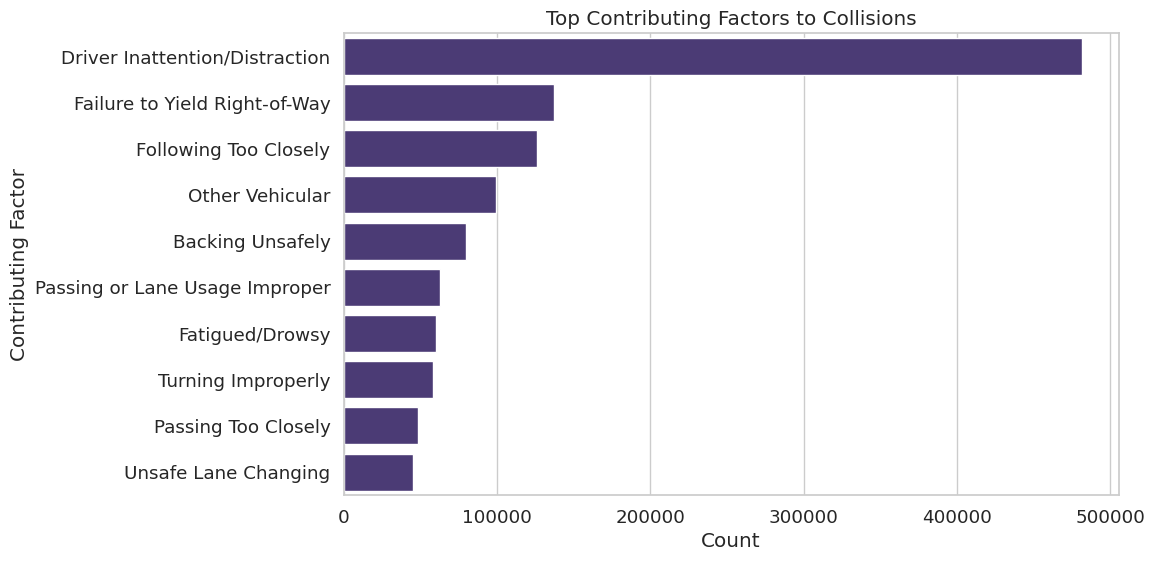

In [36]:
# Count occurrences of contributing factors
factor_counts = final_df.filter(col("CONTRIBUTING_FACTOR_1") != "Unspecified")\
    .groupBy("CONTRIBUTING_FACTOR_1").count()\
    .orderBy('count', ascending=False)\
    .limit(10).toPandas()
factor_counts.dropna(inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='CONTRIBUTING_FACTOR_1', data=factor_counts)
plt.title('Top Contributing Factors to Collisions')
plt.xlabel('Count')
plt.ylabel('Contributing Factor')
plt.gca().ticklabel_format(style='plain', axis='x')
plt.show()

2. Which boroughs in New York City have the highest number of traffic collisions?

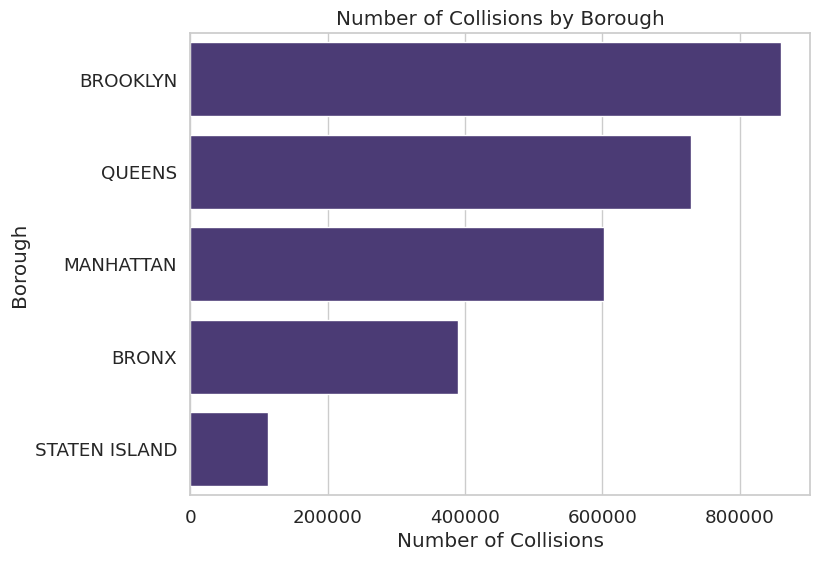

In [37]:
# Count collisions by borough
borough_counts = final_df.groupBy("BOROUGH").count().orderBy('count', ascending=False).toPandas()

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='count', y='BOROUGH', data=borough_counts)
plt.title('Number of Collisions by Borough')
plt.xlabel('Number of Collisions')
plt.ylabel('Borough')
plt.show()

3. What are the peak hours for traffic-related injuries?

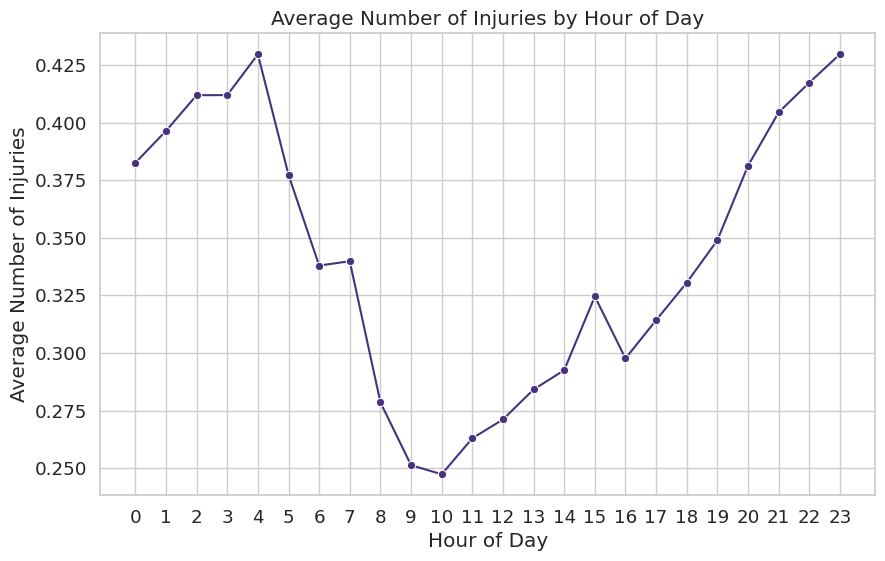

In [38]:
# Example: Correlation between time of day and number of injuries
final_df = final_df.withColumn("HOUR", hour("CRASH_TIME"))
injury_time_data = final_df.groupBy("HOUR").agg({'NUMBER_OF_PERSONS_INJURED': 'mean'}).toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x='HOUR', y='avg(NUMBER_OF_PERSONS_INJURED)', data=injury_time_data, marker='o')
plt.title('Average Number of Injuries by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Injuries')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

4. What hours of the day typically have the highest number of traffic collisions?

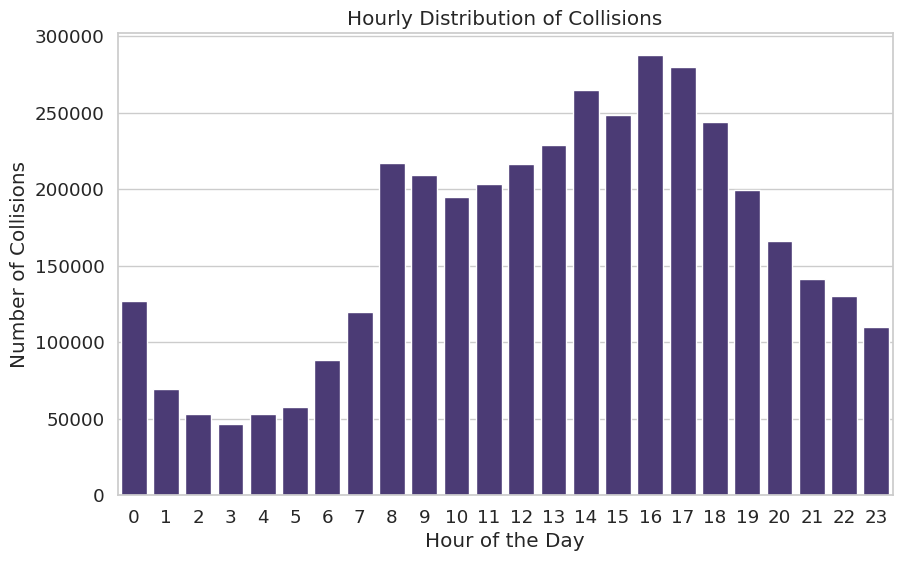

In [39]:
# Group by hour and count occurrences
hourly_distribution = final_df.groupBy("HOUR").count().orderBy("HOUR").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='HOUR', y='count', data=hourly_distribution)
plt.title('Hourly Distribution of Collisions')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Collisions')
plt.xticks(rotation=0)
plt.show()

5. What months typically see the highest and lowest numbers of traffic collisions?

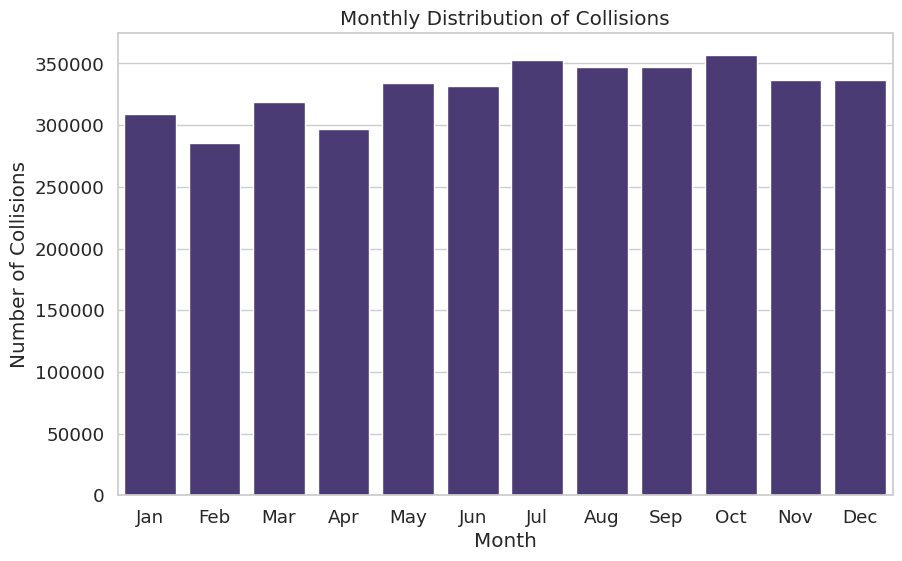

In [40]:
from pyspark.sql.functions import month
final_df = final_df.withColumn("MONTH", month("CRASH_DATETIME"))

# Group by month and count occurrences
monthly_distribution = final_df.groupBy("MONTH").count().orderBy("MONTH").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='MONTH', y='count', data=monthly_distribution)
plt.title('Monthly Distribution of Collisions')
plt.xlabel('Month')
plt.ylabel('Number of Collisions')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

6. Which types of vehicles are most frequently involved in traffic collisions?

/tmp/ipykernel_12905/1759488950.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(vehicle_collisions_pd['VEHICLE_TYPE_CODE_1'], fontsize=10)


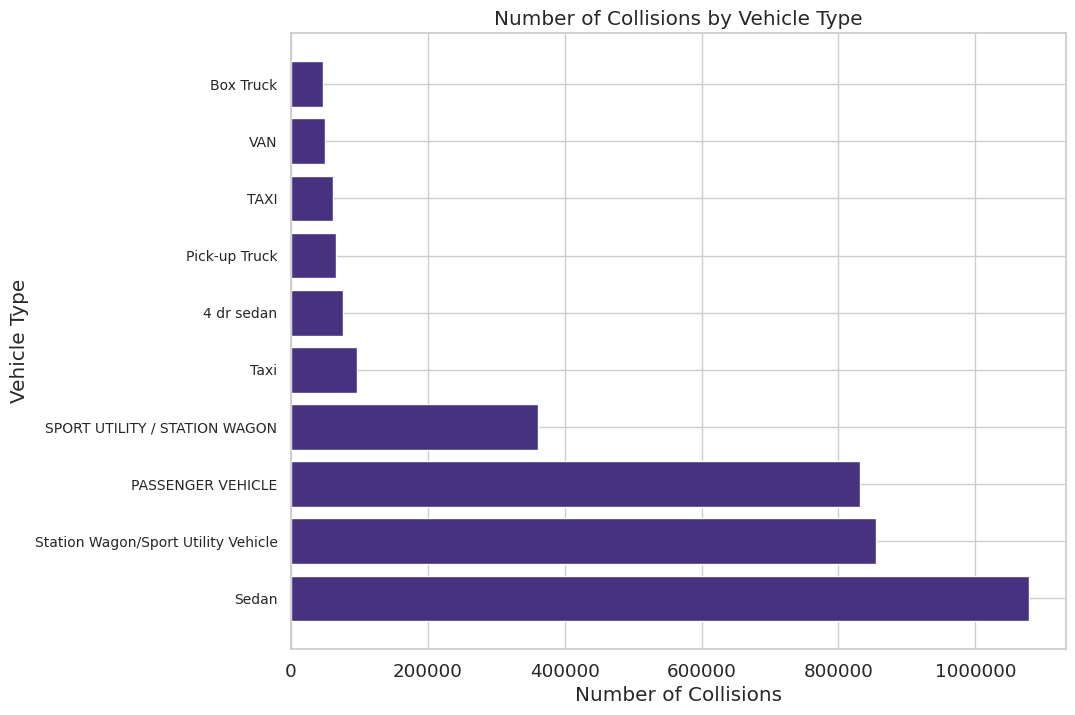

In [41]:
final_df = final_df.filter(col("VEHICLE_TYPE_CODE_1").isNotNull())

vehicle_collisions = final_df.groupBy("VEHICLE_TYPE_CODE_1").count().orderBy("count", ascending=False)

# Convert to pandas DataFrame for visualization
vehicle_collisions_pd = vehicle_collisions.limit(10).toPandas()

# Visualization
plt.figure(figsize=(10, 8))  
plt.barh(vehicle_collisions_pd['VEHICLE_TYPE_CODE_1'], vehicle_collisions_pd['count'])
plt.title('Number of Collisions by Vehicle Type')
plt.xlabel('Number of Collisions')
plt.ylabel('Vehicle Type')
plt.gca().ticklabel_format(style='plain', axis='x')
plt.gca().set_yticklabels(vehicle_collisions_pd['VEHICLE_TYPE_CODE_1'], fontsize=10) 
plt.show()

In [42]:
spark.stop()